cuda:0


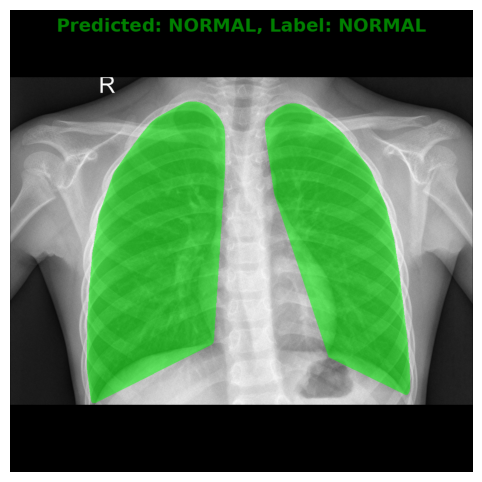

: 

In [23]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import cv2
from src.res_model import ResNetUNet
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used

# 모델 설정
unet = ResNetUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)

# 모델 로드
models_folder = Path("models")
model_name = "best_segmentation.pt"
checkpoint = torch.load(models_folder / model_name, map_location=device)
unet.load_state_dict(checkpoint)
unet.to(device)
unet.eval()

# 이미지 리사이즈 및 패딩 함수
def resize_and_pad(image, size=(1024, 1024)):
    old_size = image.size  # old_size is in (width, height) format
    ratio = float(size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    image = image.resize(new_size, Image.LANCZOS)
    new_image = Image.new("L", size)  # "L" 모드로 새 이미지 생성
    new_image.paste(image, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))
    return new_image

# 마스크 후처리 함수
def postprocess_mask(mask, min_area=1000, max_distance=50):
    mask = (mask * 255).astype(np.uint8)
    _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < min_area:
            cv2.drawContours(thresh, [contour], -1, 0, thickness=cv2.FILLED)
    new_mask = np.zeros_like(thresh)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(new_mask, [contour], -1, 255, thickness=cv2.FILLED)
    kernel = np.ones((5, 5), np.uint8)
    new_mask = cv2.morphologyEx(new_mask, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(new_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        hull = cv2.convexHull(contour)
        cv2.fillPoly(new_mask, [hull], 255)
    contours, _ = cv2.findContours(new_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    final_mask = np.zeros_like(new_mask)
    for contour in contours:
        cv2.drawContours(final_mask, [contour], -1, 255, thickness=cv2.FILLED)
    return final_mask / 255.0  # 0과 1 사이의 값으로 정규화

# 이미지 세그멘테이션 함수
def create_segmented_image(img_path):
    origin = Image.open(img_path).convert("L")  # "L" 모드로 변환
    origin = resize_and_pad(origin, (1024, 1024))
    origin_tensor = transforms.functional.to_tensor(origin).unsqueeze(0) - 0.5
    with torch.no_grad():
        origin_tensor = origin_tensor.to(device)
        out = unet(origin_tensor)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin_tensor = origin_tensor[0].to("cpu")
        out = out[0].to("cpu")
    processed_mask = postprocess_mask(out.numpy())
    return processed_mask

# 진폐증 판단 모델 설정
pneumonia_model = models.resnet152(pretrained=True)
num_features = pneumonia_model.fc.in_features
pneumonia_model.fc = nn.Linear(num_features, 2)  # Assuming binary classification
pneumonia_model.load_state_dict(torch.load("models/best_pneumonia_model.pth", map_location=device))
pneumonia_model.to(device)
pneumonia_model.eval()

# 시각화 함수
def visualize_random_result(test_dir):
    class_names = ["NORMAL", "PNEUMONIA"]
    img_list = []

    for class_name in class_names:
        class_dir = os.path.join(test_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            label = 0 if class_name == "NORMAL" else 1
            img_list.append((img_path, label))

    img_path, label = random.choice(img_list)

    # 폐영역 분리
    mask = create_segmented_image(img_path)
    mask = torch.tensor(mask).unsqueeze(0).unsqueeze(0).float().to(device)

    # 원본 이미지 로드 및 변환
    image = Image.open(img_path).convert("RGB")
    image = resize_and_pad(image, (1024, 1024))
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # 마스크를 적용하여 폐 영역만 남김
    mask_expanded = mask.expand_as(image_tensor)
    masked_image = image_tensor * mask_expanded

    # 진폐증 판단
    with torch.no_grad():
        outputs = pneumonia_model(masked_image)
        _, predicted = torch.max(outputs, 1)

    # 마스크 이미지 생성
    mask_np = mask.squeeze().cpu().numpy()
    mask_img = Image.fromarray((mask_np * 255).astype(np.uint8)).convert("L")
    mask_img = mask_img.resize(image.size, Image.NEAREST)

    # 마스크의 흰색 부분만 초록색으로 반투명하게 덮어쓰기
    mask_img_colored = Image.new("RGBA", image.size, (0, 255, 0, 128))
    mask_img_colored_np = np.array(mask_img_colored)

    mask_np_expanded = np.expand_dims(mask_np, axis=-1)
    mask_np_expanded = np.repeat(mask_np_expanded, 4, axis=-1)
    mask_img_colored_np[mask_np_expanded == 0] = 0
    mask_img_colored = Image.fromarray(mask_img_colored_np, "RGBA")

    original_image = image.convert("RGBA")
    combined_image = Image.alpha_composite(original_image, mask_img_colored)

    # 예측 결과와 정답 여부 표시
    predicted_class = class_names[predicted.item()]
    label_class = class_names[label]
    color = "green" if predicted.item() == label else "red"

    # 이미지에 텍스트 추가
    draw = ImageDraw.Draw(combined_image)
    font_size = 40  # 폰트 크기 설정
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font = ImageFont.truetype(font_path, font_size)
    text = f"Predicted: {predicted_class}, Label: {label_class}"
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_x = (combined_image.width - (text_bbox[2] - text_bbox[0])) // 2
    draw.text((text_x, 10), text, font=font, fill=color)

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.imshow(combined_image)
    plt.axis("off")
    plt.show()

# 시각화
visualize_random_result('input/chest_xray/test')
